### Note: Have to also install kaleido to save plotly images: (pip install kaleido)

In [1]:
# Imports
import math
from io import BytesIO
from PIL import (
    Image,
    ImageFont,
    ImageDraw,
)
import pandas as pd
import numpy as np
from datetime import date
from pyparsing import col
import requests
from copy import deepcopy
import plotly.express as px


In [2]:
from messari.messari import Messari
from messari.coingecko import CoinGecko
from messari.defillama import DeFiLlama
from messari.nfts import NFTPriceFloor
from messari.tokenterminal import TokenTerminal


messari = Messari('3c5078e6-c460-496f-8035-2062fabb8ed9')
coingecko = CoinGecko()
defillama = DeFiLlama()
floor = NFTPriceFloor()
tokenterminal = TokenTerminal(api_key='610b30be-e8b5-4b64-a27d-d59c94132ee4')

## Styling (Themes, colors, fonts, etc.)

In [3]:
#All themes, fonts, etc.
messari_fonts = {
    "Montserrat-Bold": "https://github.com/DustinJamesT/supply_curves/blob/999cf7f1c660f817fa0faa833f77ed76255762ef/Montserrat-Bold.ttf?raw=True",  # https://fonts.google.com/specimen/Montserrat?query=monts
    "Montserrat-Reg": "https://github.com/DustinJamesT/supply_curves/blob/6df2a17cdd9c5011bf205abfe7e50d498622feb2/Graphics/Montserrat-Regular.ttf?raw=True",
    "Montserrat-SemiBold": "https://github.com/DustinJamesT/supply_curves/blob/e4fac393fca3d51ab22d30f2d9874334bb2b7412/Graphics/Montserrat-SemiBold.ttf?raw=True",
    "Open-Sans-Reg": "https://github.com/DustinJamesT/supply_curves/blob/d04f226559f7b5970160606b357701efe3214b47/OpenSans-Regular.ttf?raw=True",  # https://fonts.google.com/specimen/Open+Sans
    "Open-Sans-semiBold": "https://github.com/DustinJamesT/supply_curves/blob/01263a2b5fe88d376e3431668c155b1d208c80d3/OpenSans-SemiBold.ttf?raw=True",
    "Open-Sans-Italic": "https://github.com/DustinJamesT/supply_curves/blob/c7f0bf1c2cfab6382bb8ec1ad812d26dcc562cad/Graphics/OpenSans-Italic.ttf?raw=True",
}

fonts = {}
for font, url in messari_fonts.items():
    font_request = requests.get(url)
    font_file = font_request.content

    fonts[font] = font_file

colors_dict = {
    'main_colors': [
        "#231DC5",
        "#1B80F3",
        "#00D1FF",
        "#7000FF",
        "#A030E5",
        "#CE66FF",
        "#16B65F",
        "#00E778",
        "#59FFCD",
        "#FFC700",
        "#FFDD64",
        "#FFF384",
        "#F5E391",
        "#F3B09B",
    ],
    # NOTE: old & out of favor colors
    'alt_colors' : [
        "#3A6495",
        "#5B8EDC",
        "#8ED7E1",
        "#B5D987",
        "#F09837",
        "#ED6E69",
        "#3668BB",
        "#40838D",
        "#608435",
        "#784D17",
    ]
}


theme_dict = {
    'light': {
        'color_pallet': colors_dict['main_colors'], # Main color pallet
        'border_color': '#232629', # off black
        'gridline_color': "#ECF0F4",  # light grey
        'text_color': "#232629",  # off black
        'title_color': "#1D1F22",  # basically black
        'subtext_color': "#A6B3C1",  # grey - used for sub title and for date
        'background_url': "https://github.com/DustinJamesT/supply_curves/blob/f940adff54e52ac13a577bb38554cffdf18b1221/Graphics/Messari_blank_light.png?raw=True", ##does not have all text (ie: Source:, Date as of:, etc.)
    },
    'dark': {
        'color_pallet': colors_dict['main_colors'], # Main color pallet
        'border_color': '#CFDBE7', # off white
        'gridline_color': "#3D434A",  # dark grey
        'text_color': "#CFDBE7",
        'title_color': "#F3F7FB",  # basically white
        'subtext_color': "#A6B3C1",  # grey - used for sub title and for date
        #'background': dark_background,
        'background_url': "https://github.com/DustinJamesT/supply_curves/blob/999cf7f1c660f817fa0faa833f77ed76255762ef/Messari_slide_clean.png?raw=True",
    }
}

yaxis_fmt_dict = {
    'percentage':".2%",
    'numeric':None
}


## Utilities

In [4]:
def create_output_image(filepath, theme, chart_title, chart_subtitle, chart_source, chart_note):

    # COMBINE IMAGES
    foreground = Image.open(f'{filepath}-raw.png')

    response = requests.get(theme_dict[theme]['background_url'])
    background = Image.open(BytesIO(response.content))
    background.paste(foreground, (50, 100), foreground)
    draw = ImageDraw.Draw(background)

    today = date.today() 
    date_text = today.strftime("%b %d, %Y")

    text_data = {
        'title':    {'text': chart_title,
                    'font': 'Montserrat-Bold','font_size': 42, 'x': 161, 'y':40, 'fill': theme_dict[theme]['title_color']}, # dont change this row
                
        'subtitle': {'text': chart_subtitle,
                    'font': 'Open-Sans-Reg' ,'font_size': 24, 'x': 165, 'y':92, 'fill': theme_dict[theme]['subtext_color']},
                
        'source':   {'text': chart_source,
                    'font': 'Open-Sans-Reg','font_size': 20, 'x': 132, 'y':792, 'fill': theme_dict[theme]['text_color']},
                
        'note':     {'text': chart_note,
                    'font': 'Open-Sans-Reg' ,'font_size': 20, 'x': 113, 'y':838, 'fill': theme_dict[theme]['text_color']},
                
        'date':     {'text': date_text,
                    'font': 'Open-Sans-semiBold','font_size': 20, 'x': 1334, 'y':831, 'fill': theme_dict[theme]['subtext_color']},
    }

    # draw text items
    for textfield, data in text_data.items():
        font = ImageFont.truetype(
            BytesIO(fonts[data["font"]]), data["font_size"]
        )
        draw.text((data['x'], data['y']), data['text'], data['fill'], font=font)
    return background


## Charting Functions

In [5]:
def create_timeseries_chart(df, chart_type, theme, chart_title, chart_subtitle, chart_source, chart_note, legend_title, legend_placement, yaxis_data_type, ytick_dollar_sign, yaxis_title, filepath):
    
    if chart_type == 'area':
        fig = px.area(df, color_discrete_sequence=theme_dict[theme]['color_pallet'])
        fig.update_traces(line={'width':0})
    elif chart_type == 'line':
        fig = px.line(df, color_discrete_sequence=theme_dict[theme]['color_pallet'])
        fig.update_traces(line={'width':3})
    elif chart_type == 'bar':
        fig = px.bar(df, color_discrete_sequence=theme_dict[theme]['color_pallet'])

    if legend_placement == 'bottom':
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
            'xaxis_title':None,
            'yaxis_title':yaxis_title,
            'legend_title':legend_title,
            'font_color':theme_dict[theme]['text_color'],
            'font_size':20,
            'width':1500,
            'height':675,
            'legend_orientation':"h", #needed for legend center bottom
            'legend_x':.5, #needed for legend center bottom
            'legend_xanchor':'center' #needed for legend center bottom
        })
    elif legend_placement == 'right':
        fig.update_layout({
            'plot_bgcolor': 'rgba(0, 0, 0, 0)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
            'xaxis_title':None,
            'yaxis_title':yaxis_title,
            'legend_title':legend_title,
            'font_color':theme_dict[theme]['text_color'],
            'font_size':20,
            'width':1500,
            'height':675
        })
    
    if ytick_dollar_sign == True:
        fig.update_layout({'yaxis_tickprefix':"$"})
    elif ytick_dollar_sign == False:
        fig.update_layout({'yaxis_tickprefix':""})
    
    fig.update_xaxes(
        showgrid=False,
        linecolor=theme_dict[theme]['border_color']
    )

    fig.update_yaxes(
        gridcolor=theme_dict[theme]['gridline_color'],
        linecolor=theme_dict[theme]['border_color'],
        zeroline=False,
        tickformat=yaxis_fmt_dict[yaxis_data_type]
    )

    fig.write_image(f'{filepath}-raw.png')
    
    background = create_output_image(filepath=filepath, theme=theme, chart_title=chart_title, chart_subtitle=chart_subtitle, chart_source=chart_source, chart_note=chart_note)
    
    background.save(f'{filepath}.png')
    
    return background
        

# Chart Examples

In [6]:
start = '2022-08-15'
end = '2022-08-29'
assets = ['Solana', 'Ethereum-Classic']

### Market Cap Example

In [7]:

mcap = messari.get_metric_timeseries(assets, 'mcap.circ', start, end, interval='1d')
display(mcap.head())

Solana  Ethereum-Classic
timestamp                                 
2022-08-15  1.564989e+10      5.664536e+09
2022-08-16  1.525320e+10      5.716023e+09
2022-08-17  1.503037e+10      5.440998e+09
2022-08-18  1.413914e+10      5.495878e+09
2022-08-19  1.378268e+10      5.397542e+09

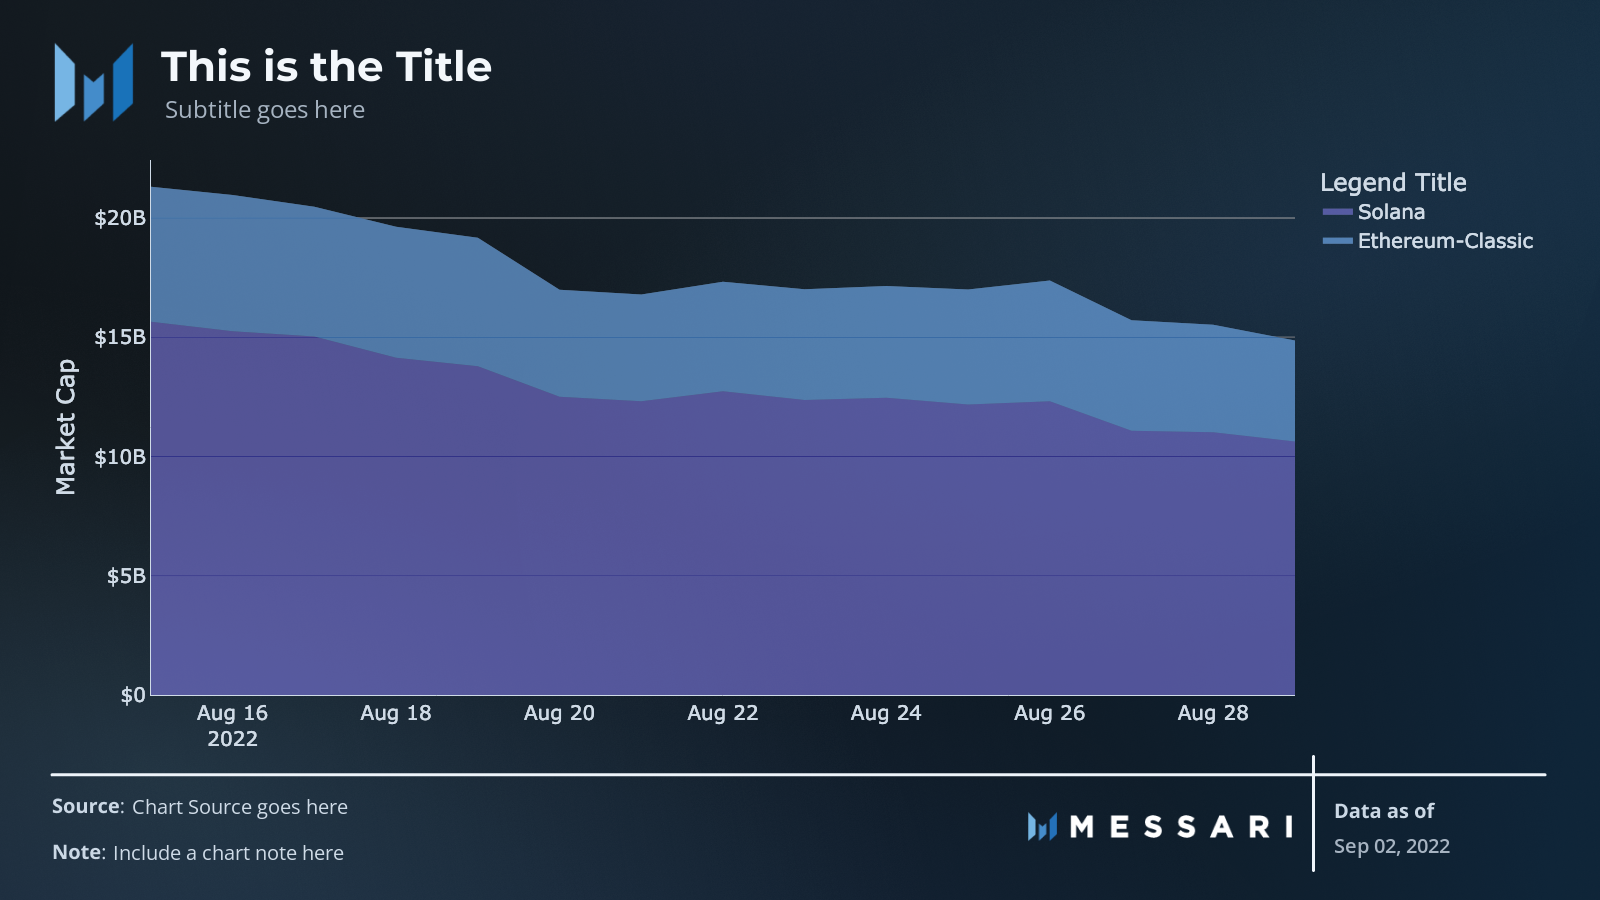

In [8]:
chart_title = 'This is the Title'
chart_subtitle = 'Subtitle goes here'
chart_source = 'Chart Source goes here'
chart_note = 'Include a chart note here'
legend_title = 'Legend Title'
yaxis_title='Market Cap'

fig = create_timeseries_chart(df=mcap, chart_type='area', theme='dark', chart_title=chart_title, chart_subtitle=chart_subtitle, chart_source=chart_source, chart_note=chart_note, legend_title=legend_title, legend_placement='right', yaxis_data_type='numeric', ytick_dollar_sign=True, yaxis_title=yaxis_title, filepath='test-image')
display(fig)

### Price chart example

In [13]:
def get_messari_prices(assets, start, end, interval='1h'):
    prices = messari.get_metric_timeseries(assets, 'price', start=start, end=end, interval=interval)
    prices = prices.xs('close', axis=1, level=1)
    return prices

p = get_messari_prices(assets, start, end, interval='1h')
display(p.head())

Solana  Ethereum-Classic
timestamp                                       
2022-08-15 00:00:00  45.576419         42.401242
2022-08-15 01:00:00  45.747364         42.913798
2022-08-15 02:00:00  46.842429         43.336454
2022-08-15 03:00:00  46.477761         42.878112
2022-08-15 04:00:00  46.414221         42.812668

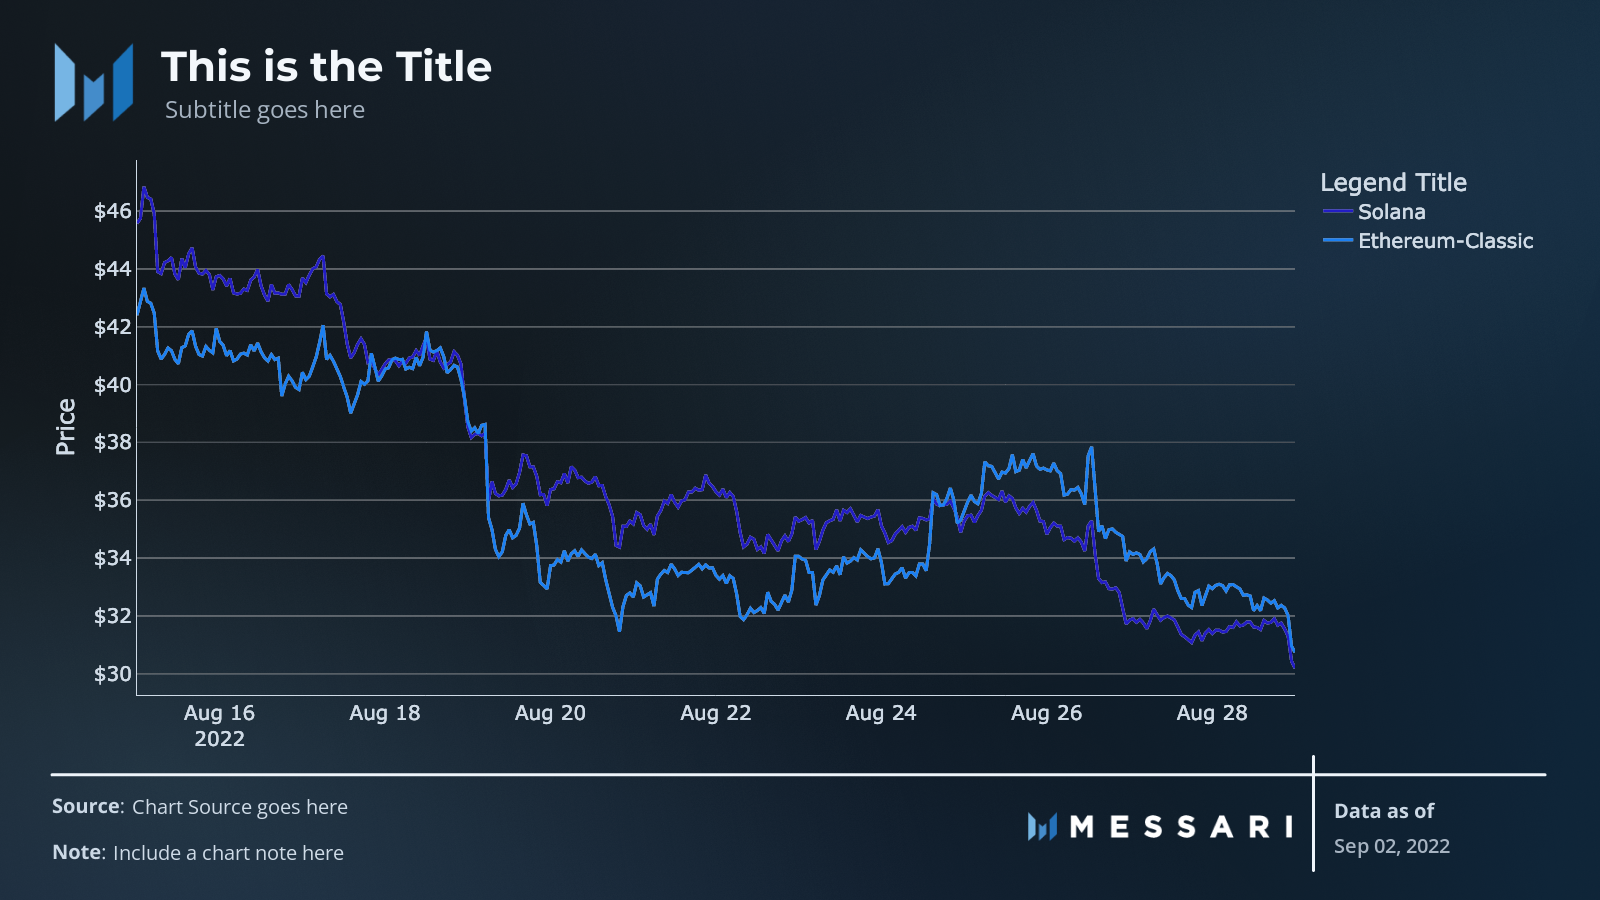

In [15]:
chart_title = 'This is the Title'
chart_subtitle = 'Subtitle goes here'
chart_source = 'Chart Source goes here'
chart_note = 'Include a chart note here'
legend_title = 'Legend Title'
yaxis_title='Price'

## Un-comment the below to run this example
fig = create_timeseries_chart(df=p, chart_type='line', theme='dark', chart_title=chart_title, chart_subtitle=chart_subtitle, chart_source=chart_source, chart_note=chart_note, legend_title=legend_title, legend_placement='right', yaxis_data_type='numeric', ytick_dollar_sign=True, yaxis_title=yaxis_title, filepath='test-image')
display(fig)


### Percentage Chart example

In [18]:
##Test Percentage Format
percentage_df = p
percentage_df['SOL Pct Change'] = percentage_df['Solana'].pct_change()
percentage_df = percentage_df[['SOL Pct Change']]
display(percentage_df.head())

SOL Pct Change
timestamp                          
2022-08-15 00:00:00             NaN
2022-08-15 01:00:00        0.003751
2022-08-15 02:00:00        0.023937
2022-08-15 03:00:00       -0.007785
2022-08-15 04:00:00       -0.001367

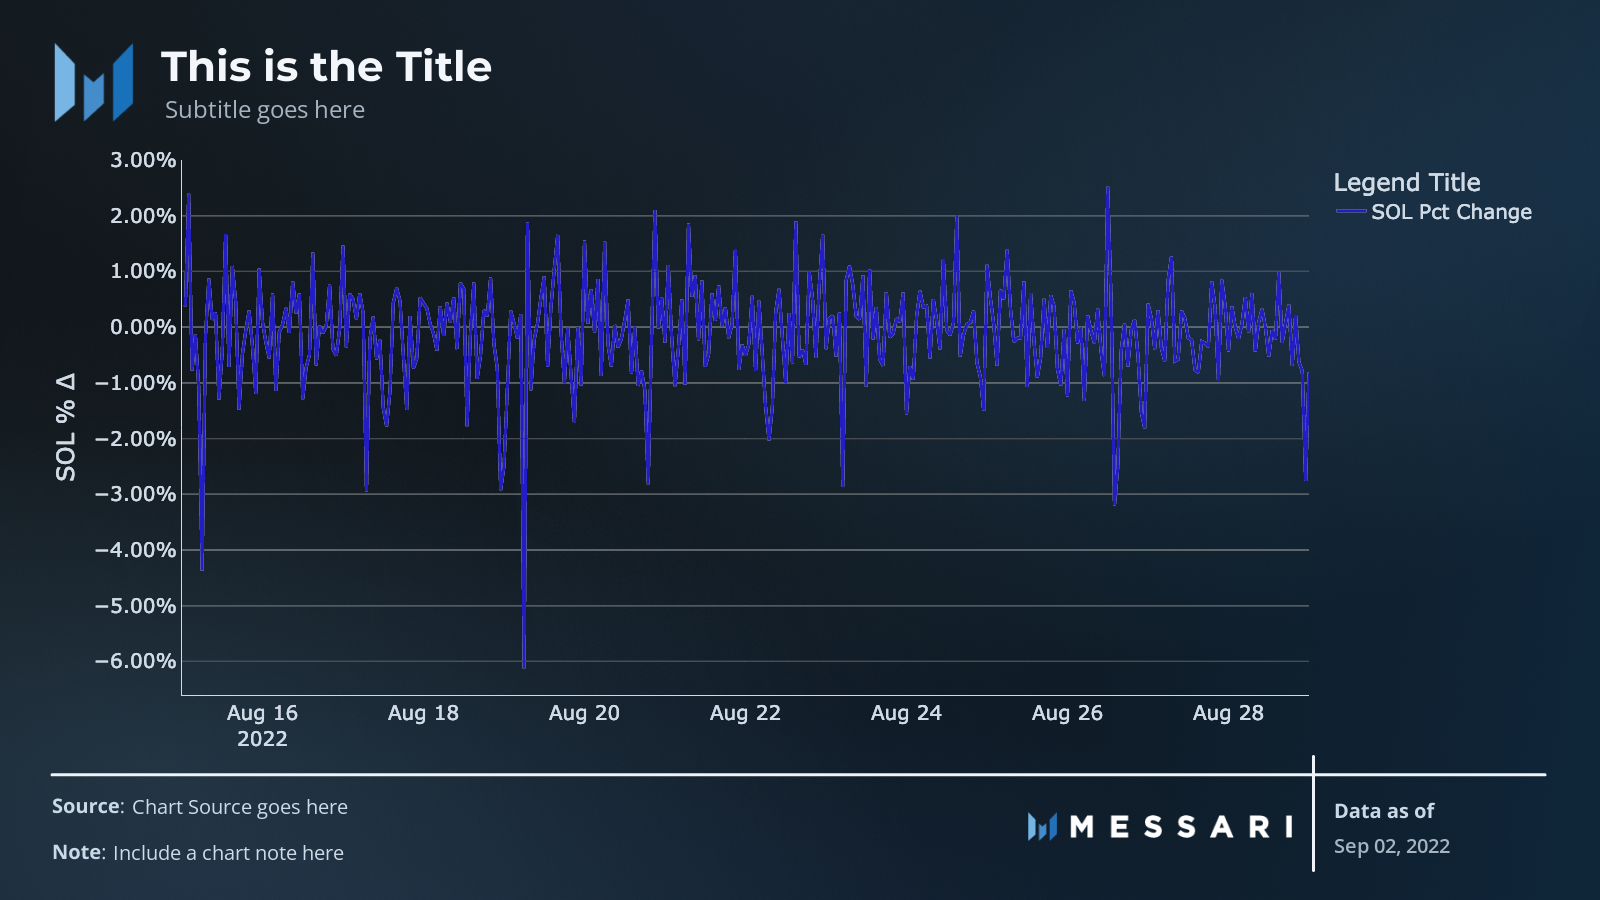

In [19]:
yaxis_title = 'SOL % ∆'


## Un-comment the below to run this example
fig2 = create_timeseries_chart(df=percentage_df, chart_type='line', theme='dark', chart_title=chart_title, chart_subtitle=chart_subtitle, chart_source=chart_source, chart_note=chart_note, legend_title=legend_title, legend_placement='right', yaxis_data_type='percentage', ytick_dollar_sign=False, yaxis_title=yaxis_title, filepath='test-image2')
display(fig2)